In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
import pickle
warnings.filterwarnings('ignore')

In [51]:
data = pd.read_csv('house.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [52]:
data=pd.read_csv('housing.csv')
data.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


In [53]:
prices=data['MEDV']

In [54]:
features=data.drop('MEDV',axis=1)
features

,RM,LSTAT,PTRATIO
0,6.575,4.98,15.3
1,6.421,9.14,17.8
2,7.185,4.03,17.8
3,6.998,2.94,18.7
4,7.147,5.33,18.7
...,...,...,...
484,6.593,9.67,21.0
485,6.120,9.08,21.0
486,6.976,5.64,21.0
487,6.794,6.48,21.0


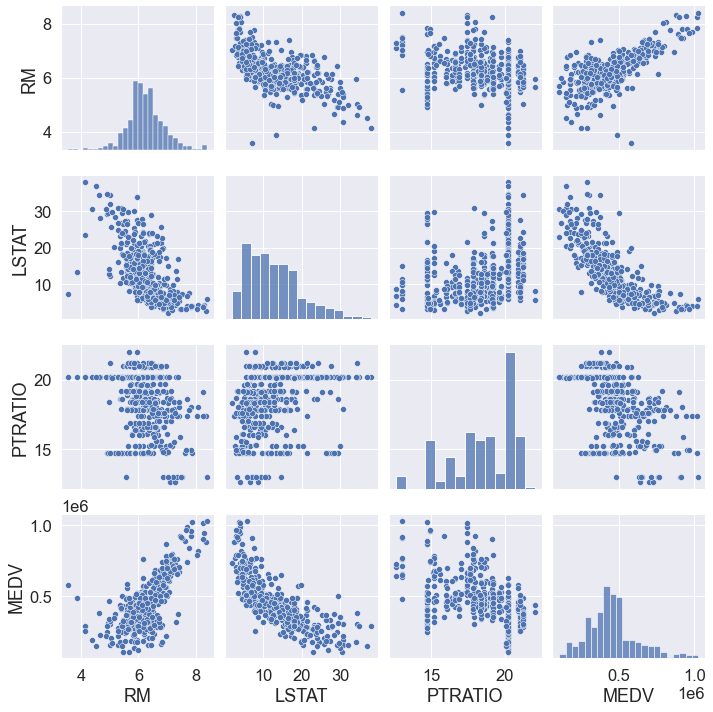

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Calculate and show pairplot
sns.pairplot(data, size=2.5)
plt.tight_layout()

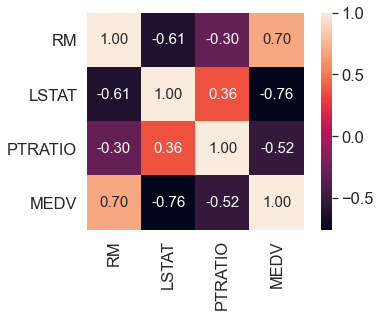

In [56]:
cols=['RM','LSTAT','PTRATIO','MEDV']
cm = np.corrcoef(data.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=cols,
                xticklabels=cols)

In [57]:
from sklearn.metrics import r2_score
def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state = 42)

In [59]:
linear_reg=LinearRegression()
# standard=StandardScaler()
# st=StandardScaler()
# X_train=standard.fit_transform(X_train)
# X_test=standard.fit_transform(X_test)
# y_train=st.fit_transform(y_train)
# y_test=st.fit_transform(y_test)
ls=linear_reg.fit(X_train,y_train)
pred=ls.predict(X_test)

In [60]:
ls.score(X_test,y_test)

0.691093400309851

In [61]:
print(performance_metric(y_test,pred))

0.691093400309851


In [62]:
def model(pipeline, parameters, X_train, y_train, X, y):
    grid_obj = GridSearchCV(estimator=pipeline,
                            param_grid=parameters,
                            cv=3,
                            scoring='r2',
                            verbose=2,
                            n_jobs=1,
                            refit=True)
    grid_obj.fit(X_train, y_train)

    '''Results'''

    results = pd.DataFrame(pd.DataFrame(grid_obj.cv_results_))
    results_sorted = results.sort_values(by=['mean_test_score'], ascending=False)
    
    print("##### Results")
    print(results_sorted)

    print("best_index", grid_obj.best_index_)
    print("best_score", grid_obj.best_score_)
    print("best_params", grid_obj.best_params_)

    '''Cross Validation'''

    estimator = grid_obj.best_estimator_
    '''
    if estimator.named_steps['scl'] == True:
        X = (X - X.mean()) / (X.std())
        y = (y - y.mean()) / (y.std())
    '''
    shuffle = KFold(n_splits=5,shuffle=True,random_state=0)
    cv_scores = cross_val_score(estimator,
                                X,
                                y.values.ravel(),
                                cv=shuffle,
                                scoring='r2')
    print("##### CV Results")
    print("mean_score", cv_scores.mean())

    '''Show model coefficients or feature importances'''
    try:
        print("Model coefficients: ", list(zip(list(X), estimator.named_steps['clf'].coef_)))
    except:
        print("Model does not support model coefficients")
    try:
        print("Feature importances: ", list(zip(list(X), estimator.named_steps['clf'].feature_importances_)))
    except:
        print("Model does not support feature importances")

    '''Predict along CV and plot y vs. y_predicted in scatter'''

    y_pred = cross_val_predict(estimator, X, y, cv=shuffle)

    plt.scatter(y, y_pred)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
    plt.xlabel("True prices")
    plt.ylabel("Predicted prices")
    plt.annotate(' R-squared CV = {}'.format(round(float(cv_scores.mean()), 3)), size=9,
             xy=(xmin,ymax), xytext=(10, -15), textcoords='offset points')
    plt.annotate(grid_obj.best_params_, size=9,
                 xy=(xmin, ymax), xytext=(10, -35), textcoords='offset points', wrap=True)
    plt.title('Predicted prices (EUR) vs. True prices (EUR)')
    plt.show()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.020674      0.001745         0.008949        0.001675     {}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.664374            0.70415           0.757688         0.708737   

   std_test_score  rank_test_score  
0        0.038233                1  
best_index 0
best_score 0.708737169337665
best_params {}
##### CV Results
mean_score 0.711345912008384
Model coefficients:  [('RM', 58790.17113748401), ('LSTAT', -75604.39691794886), ('PTRATIO', -42110.89258824107)]
Model does not support feature importances


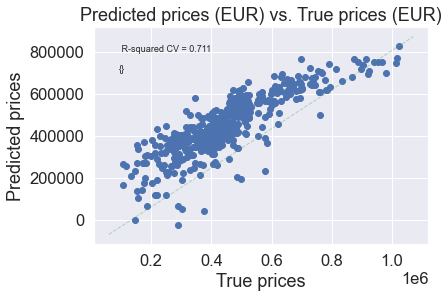

In [63]:
pipe_ols = Pipeline([('scl', StandardScaler()),
           ('clf', LinearRegression())])

param_ols = {}

model(pipe_ols, param_ols, X_train, y_train, features,prices)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7; total time=   0.1s
[CV] END clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7; total time=   0.0s
[CV] END clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7; total time=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.157687      0.027802         0.010005        0.004764   

  param_clf__colsample_bytree param_clf__gamma param_clf__max_depth  \
0                           1             0.01                    5   

  param_clf__min_child_weight param_clf__subsample  \
0                           6                  0.7   

                                              params  split0_test_score  \
0  {'clf__colsample_bytree': 1, 'clf__gamma': 0.0...           0.7

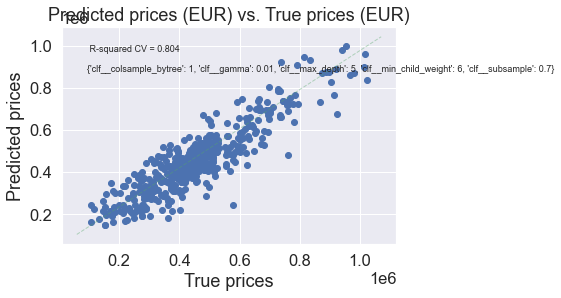

In [64]:
pipe_xgb = Pipeline([('clf', xgb.XGBRegressor())])

param_xgb = {'clf__max_depth':[5],
             'clf__min_child_weight':[6],
             'clf__gamma':[0.01],
             'clf__subsample':[0.7],
             'clf__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train, y_train,features,prices)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .................................clf__n_neighbors=5; total time=   0.0s
[CV] END .................................clf__n_neighbors=5; total time=   0.0s
[CV] END .................................clf__n_neighbors=5; total time=   0.0s
[CV] END ................................clf__n_neighbors=10; total time=   0.0s
[CV] END ................................clf__n_neighbors=10; total time=   0.0s
[CV] END ................................clf__n_neighbors=10; total time=   0.0s
[CV] END ................................clf__n_neighbors=15; total time=   0.0s
[CV] END ................................clf__n_neighbors=15; total time=   0.0s
[CV] END ................................clf__n_neighbors=15; total time=   0.0s
[CV] END ................................clf__n_neighbors=25; total time=   0.0s
[CV] END ................................clf__n_neighbors=25; total time=   0.0s
[CV] END ................................clf__n_n

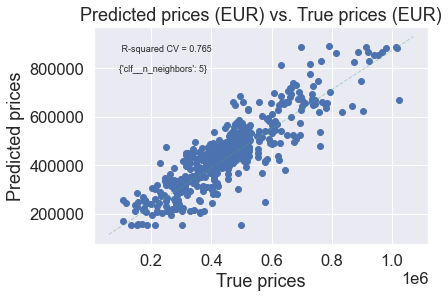

In [65]:
# Pipeline and Parameters - KNN

pipe_knn = Pipeline([('clf', KNeighborsRegressor())])

param_knn = {'clf__n_neighbors':[5, 10, 15, 25, 30]}

model(pipe_knn, param_knn, X_train, y_train,features,prices)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END ......................................clf__alpha=10; total time=   0.0s
[CV] END ......................................clf__alpha=10; total time=   0.0s
[CV] END ......................................cl

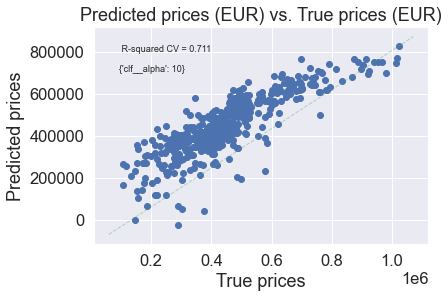

In [66]:
# Pipeline and Parameters - Lasso
pipe_lasso = Pipeline([('scl', StandardScaler()),
           ('clf', Lasso(max_iter=1500))])
param_lasso = {'clf__alpha': [0.01, 0.1, 1, 10]}
model(pipe_lasso, param_lasso, X_train, y_train,features,prices)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END ....................................clf__alpha=0.01; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .....................................clf__alpha=0.1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END .......................................clf__alpha=1; total time=   0.0s
[CV] END ......................................clf__alpha=10; total time=   0.0s
[CV] END ......................................clf__alpha=10; total time=   0.0s
[CV] END ......................................cl

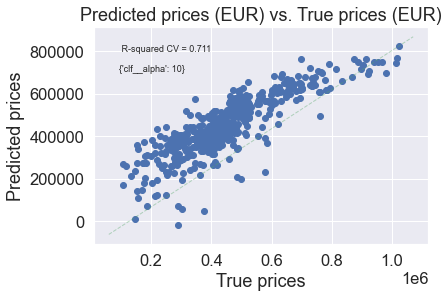

In [67]:
# Pipeline and Parameters - Ridge
pipe_ridge = Pipeline([('scl', StandardScaler()),
           ('clf', Ridge())])
param_ridge = {'clf__alpha': [0.01, 0.1, 1, 10]}
model(pipe_ridge, param_ridge, X_train, y_train,features,prices)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ...............................polynomial__degree=2; total time=   0.0s
[CV] END ...............................polynomial__degree=2; total time=   0.0s
[CV] END ...............................polynomial__degree=2; total time=   0.0s
[CV] END ...............................polynomial__degree=4; total time=   0.0s
[CV] END ...............................polynomial__degree=4; total time=   0.0s
[CV] END ...............................polynomial__degree=4; total time=   0.0s
[CV] END ...............................polynomial__degree=6; total time=   0.0s
[CV] END ...............................polynomial__degree=6; total time=   0.0s
[CV] END ...............................polynomial__degree=6; total time=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.021339      0.002773         0.007283        0.002502   
1       0.022493      0.005296         0.007292        0.000518 

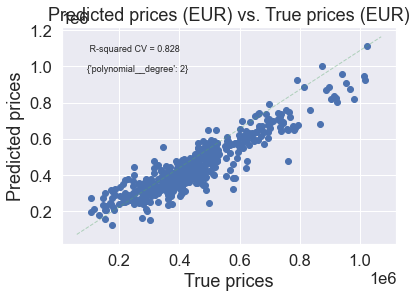

In [68]:
# Pipeline and Parameters - Polynomial Regression

pipe_poly = Pipeline([('scl', StandardScaler()),
                       ('polynomial', PolynomialFeatures()),
                       ('clf', LinearRegression())])
param_poly = {'polynomial__degree': [2, 4, 6]}
model(pipe_poly, param_poly, X_train, y_train,features,prices)



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..........clf__max_depth=2, clf__min_samples_leaf=5; total time=   0.0s
[CV] END ..........clf__max_depth=2, clf__min_samples_leaf=5; total time=   0.0s
[CV] END ..........clf__max_depth=2, clf__min_samples_leaf=5; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=10; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=10; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=10; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=50; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=50; total time=   0.0s
[CV] END .........clf__max_depth=2, clf__min_samples_leaf=50; total time=   0.0s
[CV] END ........clf__max_depth=2, clf__min_samples_leaf=100; total time=   0.0s
[CV] END ........clf__max_depth=2, clf__min_samples_leaf=100; total time=   0.0s
[CV] END ........clf__max_depth=2, clf__min_samp

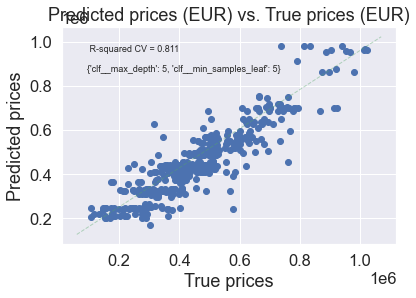

In [69]:
# Pipeline and Parameters - Decision Tree Regression

pipe_tree = Pipeline([('clf', DecisionTreeRegressor())])

param_tree = {'clf__max_depth': [2, 5, 10],
             'clf__min_samples_leaf': [5,10,50,100]}
model(pipe_tree, param_tree, X_train, y_train,features,prices)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=10; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=10; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=10; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=20; total time=   1.0s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=20; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=20; total time=   0.0s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=50; total time=   0.1s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=50; total time=   0.1s
[CV] END clf__max_depth=1, clf__max_features=None, clf__n_estimators=50; total time=   0.1s
[CV] END clf__max_depth=1, clf__max_features=1, clf__n_estimators=10; total time=   0.0s
[CV] END clf__max_dept

##### CV Results
mean_score 0.8474378536269527
Model does not support model coefficients
Feature importances:  [('RM', 0.38818930463823703), ('LSTAT', 0.5312934736340552), ('PTRATIO', 0.0805172217277076)]


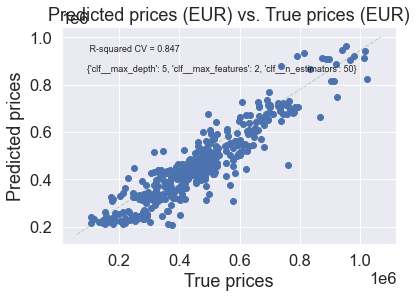

In [70]:
# Pipeline and Parameters - Random Forest

pipe_forest = Pipeline([('clf', RandomForestRegressor())])

param_forest = {'clf__n_estimators': [10, 20, 50],
                'clf__max_features': [None, 1, 2],
                'clf__max_depth': [1, 2, 5]}

model(pipe_forest, param_forest, X_train, y_train,features,prices)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(

[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.2s
[CV] END clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.2s
[CV] EN

[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.3s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invsca

[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.3s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs; total time=   0.1s
[CV] END clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__sol

##### CV Results
mean_score 0.8272002078482561
Model does not support model coefficients
Model does not support feature importances


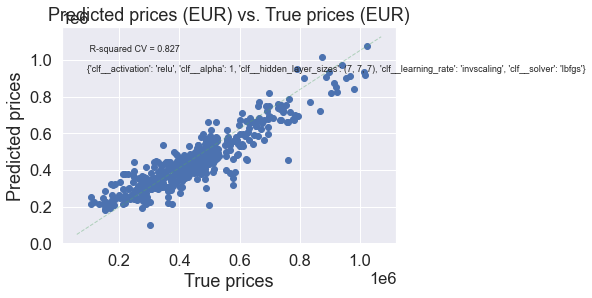

In [71]:
# Pipeline and Parameters - MLP Regression

pipe_neural = Pipeline([('scl', StandardScaler()),
                        ('clf', MLPRegressor())])

param_neural = {'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                'clf__hidden_layer_sizes': [(5),(10,10),(7,7,7)],
                'clf__solver': ['lbfgs'],
                'clf__activation': ['relu', 'tanh'],
                'clf__learning_rate' : ['constant', 'invscaling']}

model(pipe_neural, param_neural, X_train, y_train,features,prices)

In [81]:
rfreg=RandomForestRegressor(n_estimators=50,max_depth=5,max_features=2)
rfreg.fit(X_train,y_train)
y_pred=rfreg.predict((X_test))
r_sqare=performance_metric(y_test,y_pred)
print(r_sqare)  
pickle.dump(rfreg,open("rfreg.pkl",'wb'))

0.8588561728416937
